# 02. Epidemic Spreading on Activity Driven Networks

In this notebook, we will create a simple python code that simulate a simple SIR model on activity driven networks.


In [1]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import networkx as nx

We consider a simple SIR model described by the following transitions:
$$S + I \xrightarrow{\lambda} 2I$$
$$I \xrightarrow{\mu} R$$

First, we import the function to generate activity driven network from notebook `01_activity_driven_networks.ipynb`:

In [2]:
def sample_activity(eps, alpha):
    """
    This function samples the activity from a distribution F(a) ~ a^-alpha
    Parameters
    ----------
        @param eps: the minimum activity value
        @param alpha: the exponent of the power law distribution
    Returns
    -------
        @return: the sampled activity
    """
    y = random.random()
    a = (y + (1 - y) * (eps ** (1 - alpha))) ** (1 / (1 - alpha))
    return a

def sample_neighbours(index, m, N):
    """
    This function samples the neighbours
    Parameters
    ----------
        @param index: source node index
        @param m: number of neighbours to sample
        @param N: total number of nodes
    Returns
    -------
        @return: the sampled neighbours
    """
    return np.random.choice([idx for idx in range(N) if idx != index], size=m)

Then, we define a function to simulate the SIR model on activity driven networks. We notice how it is not necessary to simulate the whole network, but we are only interested in generating the links that may results in an infection (i.e., the only transition mediated by interactions)

In [3]:
def initialize(i0, N):
    """
    This function initializes the network assigning a health status to each node
    Parameters
    ----------
        @param i0: initial fraction of infected nodes
        @param N: total number of nodes
    Returns
    -------
        @return: total number of S, I, R nodes and list of susceptible/infected indicators
    """
    S, I, R = N, 0, 0
    infected = np.array([1 if random.random() < i0 else 0 for i in range(N)])
    susceptible = np.ones(N) - infected
    I = np.sum(infected)
    S = N - I - R
    return S, I, R, infected, susceptible


def simulate(i0, N, mu, m, lambda_val, T, activities):
    """
    This function simulated the SIR model on activity driven network
    Parameters
    ----------
        @param i0: initial fraction of infected nodes
        @param N: total number of nodes
        @param mu: recovery rate
        @param m: number of neighbours to sample
        @param lambda_val: transmission rate of a single contact
        @param T: number of simulation steps
        @param activities: nodes activities
    Returns
    -------
        @return: simulated incidence and evolution of different compartments
    """
    
    S, I, R, infected, susceptible = initialize(i0, N)
    incidence = []
    compartments = {"S": [S], "I": [I], "R": [R]}
    for t in range(T):
        newI, newR = [], []

        for i in range(N):
            # if node is susceptible
            if susceptible[i] == 1:
                # if node is active
                if random.random() < activities[i]:
                    neighbours = sample_neighbours(i, m, N)
                    for neighbour in neighbours:
                        if infected[neighbour] == 1:
                            if random.random() < lambda_val:
                                newI.append(i) # infect

            # if node is infected
            elif infected[i] == 1:
                # if node is active
                if random.random() < activities[i]:
                    neighbours = sample_neighbours(i, m, N)
                    for neighbour in neighbours:
                        if susceptible[neighbour] == 1:
                            if random.random() < lambda_val:
                                newI.append(neighbour) # infect

                # check recovery
                if random.random() < mu:
                    newR.append(i)

        for j in newI:
            if infected[j] == 0:
                infected[j] = 1
                susceptible[j] = 0
                S -= 1
                I += 1

        for j in newR:
            if infected[j] == 1:
                infected[j] = 0
                I -= 1
                R += 1
        
        incidence.append(len(newI))

        compartments["S"].append(S)
        compartments["I"].append(I)
        compartments["R"].append(R)

    return incidence, compartments

Finally, we test the function and plot the results:

In [4]:
activities = np.array([sample_activity(eps=10**(-3), alpha=2.1) for i in range(5000)])
incidence, compartments = simulate(i0=0.05, N=5000, mu=0.01, m=2, lambda_val=0.5, T=1000, activities=activities)

Text(0.5, 0, 'T')

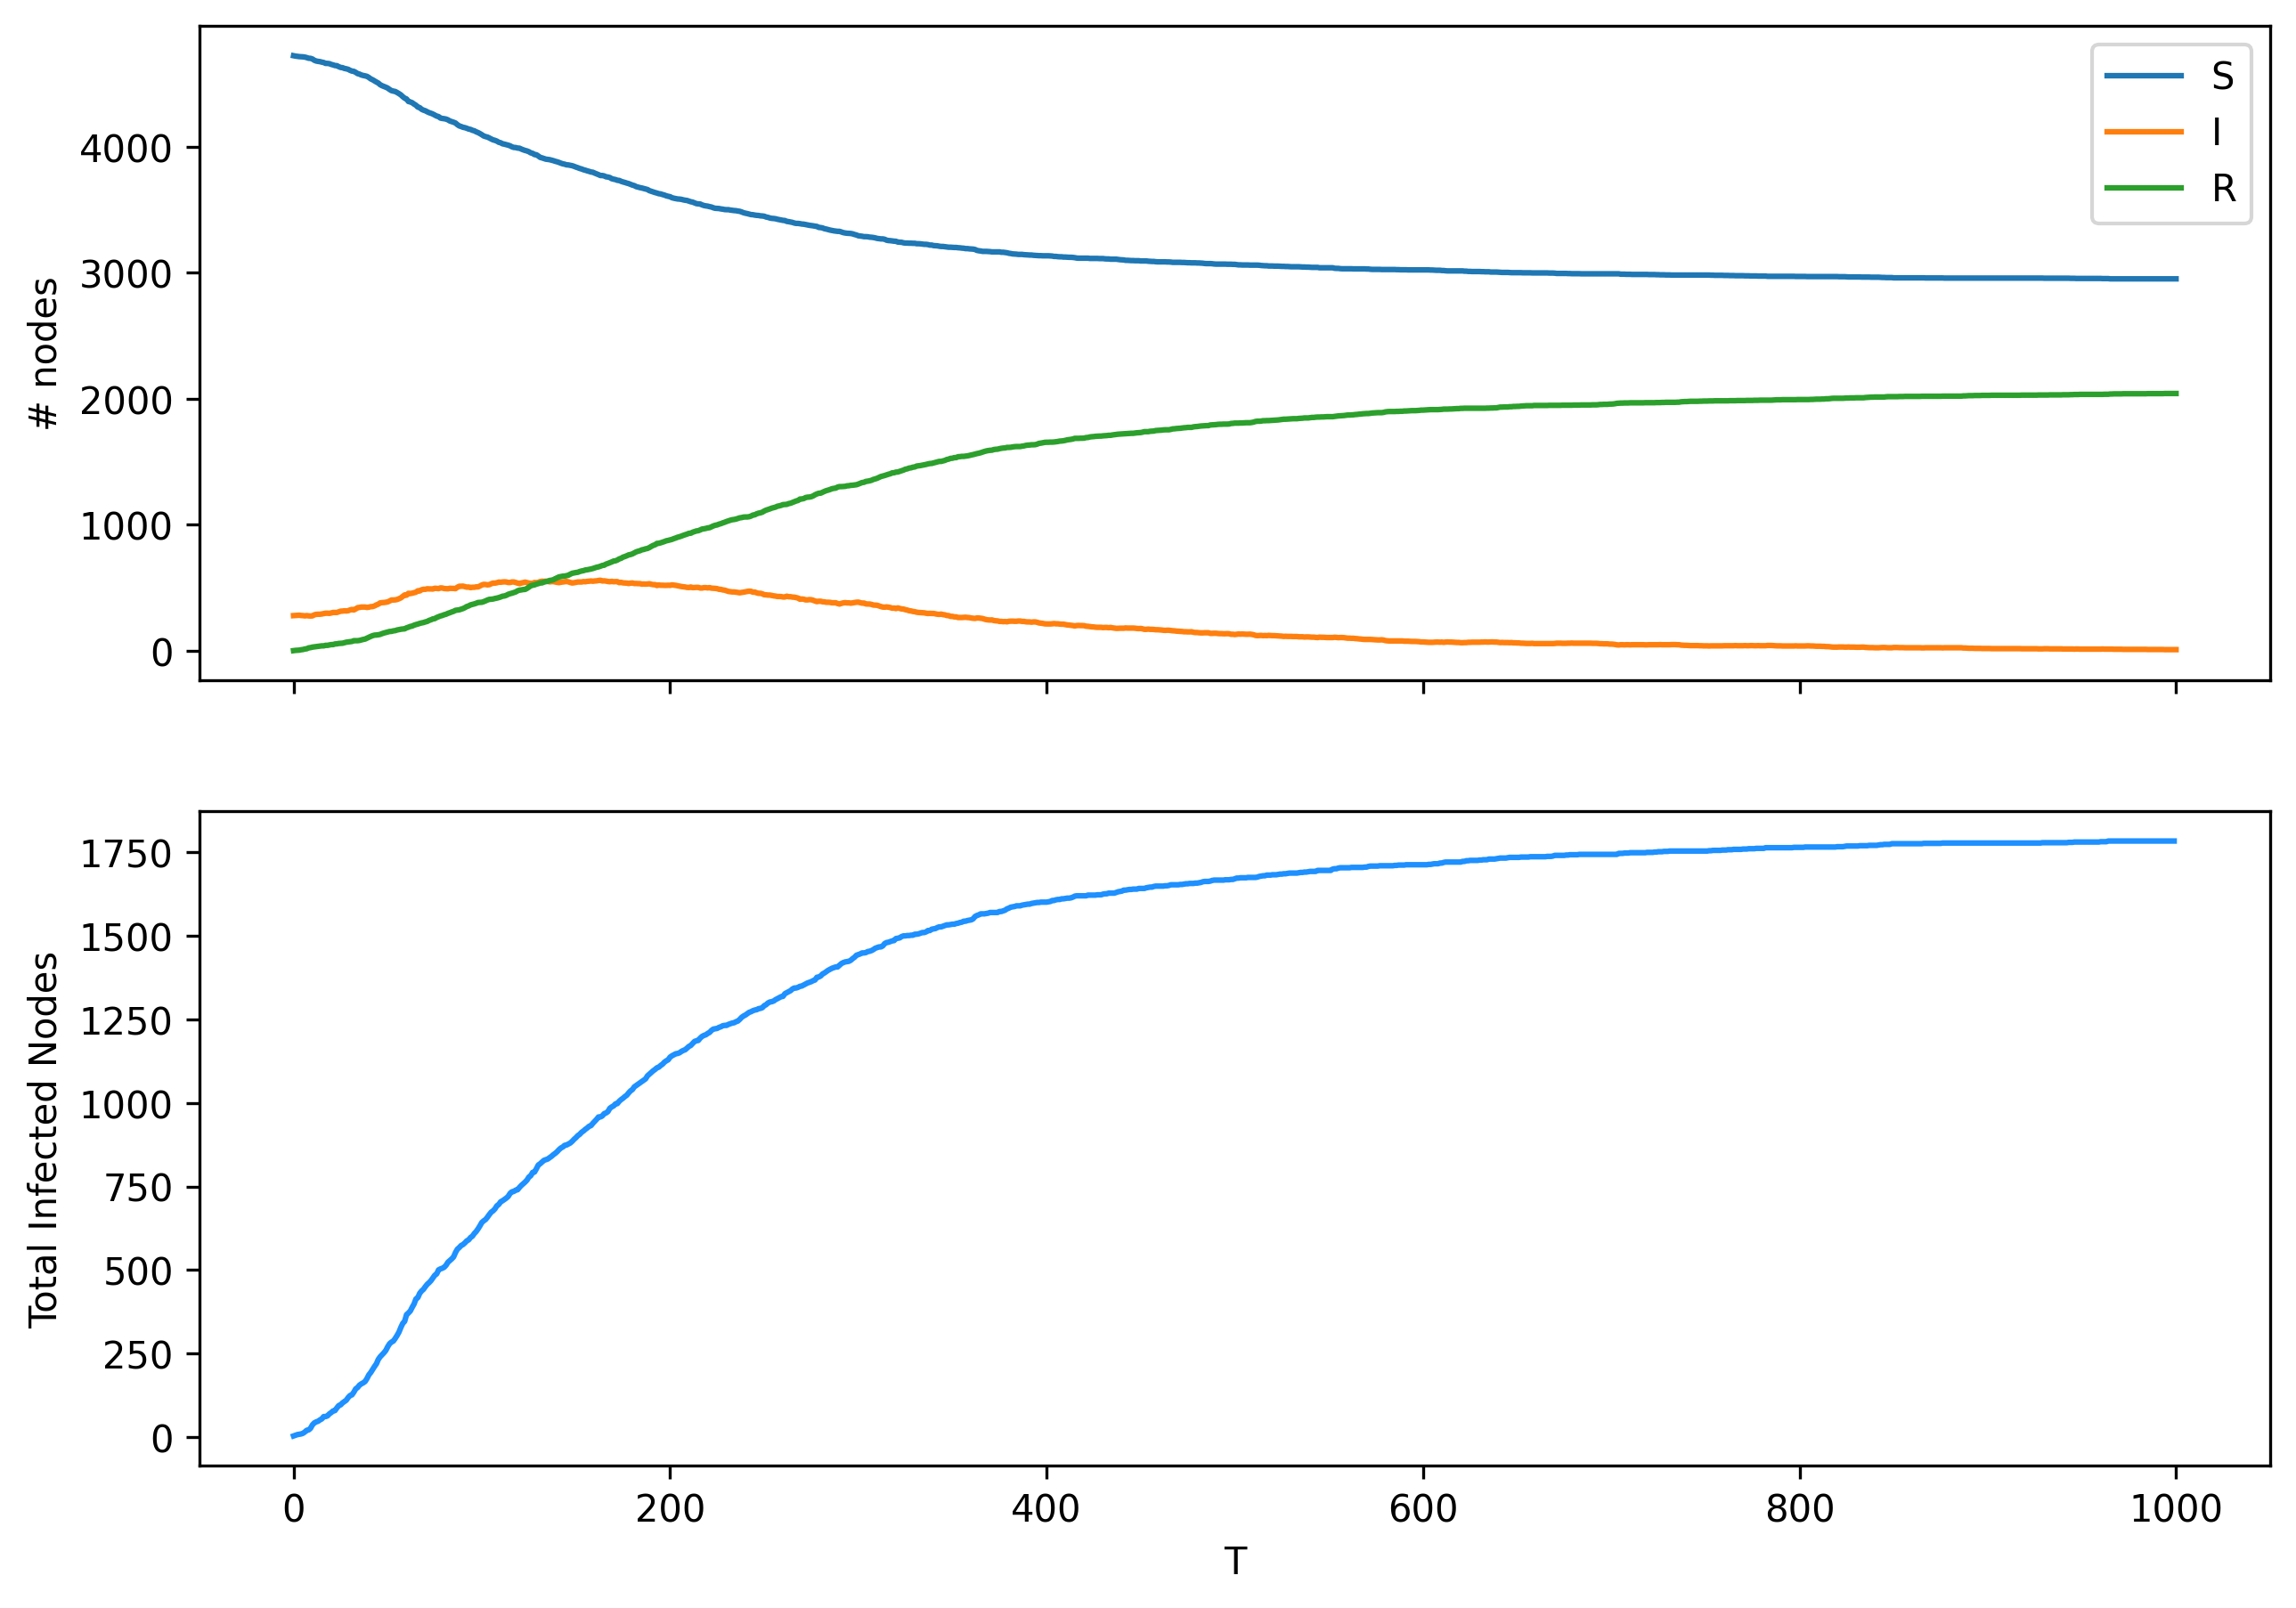

In [5]:
fig, axes = plt.subplots(nrows=2, sharex=True, dpi=300, figsize=(10,7))

axes[0].plot(compartments["S"], label="S")
axes[0].plot(compartments["I"], label="I")
axes[0].plot(compartments["R"], label="R")
axes[0].set_ylabel("# nodes")
axes[0].legend()

axes[1].plot(np.cumsum(incidence), color="dodgerblue")
axes[1].set_ylabel("Total Infected Nodes")
axes[1].set_xlabel("T")